# BERTopic

In [ ]:
!pip install bertopic
!pip install bertopic[flair]
!pip install bertopic[gensim]
!pip install bertopic[spacy]
!pip install bertopic[use]

In [ ]:
### Run environment setup
import os
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
import pandas as pd
import nltk
import re
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords[:10])

### Define folders
base_folder = '/content/drive/MyDrive/Unibo/DM_TM_BDA/2022_23/Modulo 3 - TM/Project'

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def sentence_preprocess(sentence, stopwords=stopwords, min_sentence_len=3):
    """
    This function can be used in order to preprocess a given character sentence
    ## Params
    * `sentence`: the sentence to preprocess
    * `stopwords`: is a set of stopwords, the default value of such parameter is the set of 
    english stopwords of the library nltk
    * `min_sentence_len`: is the minimum lenght a sentence should have in order to be preprocessed
    and remain in the dataset
    ## Returns
    The preprocessed sentence
    """
    # lower sentence
    sentence = sentence.lower()
    # substitute punctuations with single space
    sentence = re.sub(r'[^A-Za-z\s]', ' ', sentence)
    # split sentences
    sentence_splitted = sentence.split()
    # check if the sentence is too short
    is_short = len(sentence_splitted) <= min_sentence_len
    # check if the sentence contains at least a non stopword
    is_relevant = False
    for word in sentence_splitted:
        if word not in stopwords:
            is_relevant = True
        else:
            # remove stopwords
            sentence = sentence.replace(word, "")
    # substitutes multiple spaces with one single
    sentence = re.sub(r'\s+', ' ', sentence)
    # remove left and right space 
    sentence = sentence.lstrip().rstrip()
    # returns the sentence preprocessed and the final relence of it
    return sentence, (not is_short and is_relevant)

In [ ]:
df = pd.read_csv(os.path.join(base_folder, 'Barney.csv'))
docs = df['response'].to_list()
print(len(docs))
docs_prepr = []
y = []
for d in docs:
    snt_prp = sentence_preprocess(d)
    if snt_prp[1]:
        docs_prepr.append(snt_prp[0])
        y.append(0)

5194


Ora per Sheldon

In [ ]:
df = pd.read_csv(os.path.join(base_folder, 'Sheldon.csv'))
docs = df['response'].to_list()
print(len(docs))
for d in docs:
    snt_prp = sentence_preprocess(d)
    if snt_prp[1]:
        docs_prepr.append(snt_prp[0])
        y.append(1)

11642


In [ ]:
empty_dimensionality_model = BaseDimensionalityReduction()
clf = LogisticRegression()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

In [ ]:
docs_prepr[:5]

['hey k lwys thng hlf sn grls well got new fvorte lebnese grls lebnese grls re new hlf sns',
 'okay et bar fifteen mutes suit',
 'ut jut y ut wh put ut',
 'blzer',
 'see ths s forgotten sad nght met']

In [ ]:
topic_model= BERTopic(
        umap_model=empty_dimensionality_model,
        hdbscan_model=clf,
        ctfidf_model=ctfidf_model,
        verbose=True
)
topics, probs = topic_model.fit_transform(docs_prepr, y=y)

Batches:   0%|          | 0/442 [00:00<?, ?it/s]

2023-03-05 17:48:02,228 - BERTopic - Transformed documents to Embeddings
2023-03-05 17:48:02,230 - BERTopic - The dimensionality reduction algorithm did not contain the `y` parameter and therefore the `y` parameter was not used
2023-03-05 17:48:02,232 - BERTopic - Reduced dimensionality
2023-03-05 17:48:02,969 - BERTopic - Clustered reduced embeddings


In [ ]:
max(topics)

1

In [ ]:
# topic_model.get_document_info(docs_prepr)

In [ ]:
# topic_model.get_topic(0)

In [ ]:
topic_model.visualize_documents(docs_prepr)

In [ ]:
mappings = topic_model.topic_mapper_.get_mappings()
mappings = {value: y[key] for key, value in mappings.items()}

df = topic_model.get_topic_info()
df["Class"] = df.Topic.map(mappings)
df

,Topic,Count,Name,Class
0,0,9931,0_oh_im_well_dont,0
1,1,4202,1_ted_he_know_go,0


In [ ]:
mappings = topic_model.topic_mapper_.get_mappings()
y_mapped = [mappings[val] for val in y]
y_mapped[-1]

0

In [ ]:
y[-10:]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# DistilBERT embedder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U sklearn
!pip install -U datasets transformers happytransformer sentence_transformers torchmetrics nlg-metricverse

In [3]:
!git clone https://github.com/falric05/ChatBot-Personality-Recognition
!mv /content/ChatBot-Personality-Recognition/notebooks/lib .
!rm -r /content/ChatBot-Personality-Recognition
!cp -r "/content/drive/MyDrive/Unibo/TM/Data" .
!mkdir /content/models
!mkdir /content/models/distilbert_embedder
!mkdir /content/models/distilbert_classifier

Cloning into 'ChatBot-Personality-Recognition'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 103 (delta 40), reused 80 (delta 17), pack-reused 0
Receiving objects: 100% (103/103), 1.86 MiB | 7.12 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [4]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from os.path import join
from copy import deepcopy
from functools import partial
from random import sample
import pandas as pd

# from random import shuffle
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# Import (tf) model and tokenizer structures from HuggingFace
from transformers import AutoTokenizer, pipeline, DistilBertTokenizer, DistilBertModel


from lib.BBData import character_dict, random_state, model_name
from lib.BBDataLoad import load_char_df, get_chatbot_predictions
# from lib.BBVisualizations import BBVisualization, PlotsEnum
!python -m nltk.downloader stopwords
from lib.metrics.triplet_nn_classifier import BarneyBotTripletClassifier
from lib.metrics.distil_bert_classifier import DistilBertClassifier
from lib.metrics.frequency import sentence_preprocess, FrequencyClassifier
from lib.visualizations.emotionsradar import EmotionsRadar

/usr/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Setup

In [5]:
characters = list(character_dict.keys())
characters_noDefault = list(character_dict.keys())
characters_noDefault.remove('Default')
base_folder = os.getcwd()
data_folder = join(base_folder, 'Data', 'Characters')
model_folder = join(base_folder, 'models')
out_folder = os.getcwd().join('tmp')
figsize = (8, 8)

## DistilBERT classifier

In [6]:
embedder_path = join(os.getcwd(), 'models', 'distilbert_embedder')
classifier_path = join(os.getcwd(), 'models', 'distilbert_classifier')

In [7]:
!ls /usr/local/

bin    cuda	cuda-11.8  games	       images	lib	   man	 share
colab  cuda-11	etc	   _gcs_config_ops.so  include	licensing  sbin  src


In [8]:
distilbert_model = DistilBertClassifier(embedder_path=embedder_path, use_cuda=True, from_pretrained = False, n_triplets_x_anchor=3)

In [9]:
# add default
distilbert_model.set_characters(characters)

Creating triplets...


100%|██████████| 8240/8240 [00:39<00:00, 207.10it/s]


Creating triplets...


100%|██████████| 468/468 [00:00<00:00, 2229.86it/s]


Training embedder
####################################################################################################
step 1/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:01<00:00, 66530.86it/s]

Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 46.65%	(+46.65%)

Dataset lenght    : 38559

Train Accuracy    : 51.99%	(+51.99%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

Iteration:   0%|          | 0/302 [00:00<?, ?it/s]

####################################################################################################
step 2/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:01<00:00, 60770.23it/s]


Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 37.89%	(-8.76%)

Dataset lenght    : 57557

Train Accuracy    : 77.61%	(+25.62%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/450 [00:00<?, ?it/s]

Iteration:   0%|          | 0/450 [00:00<?, ?it/s]

Iteration:   0%|          | 0/450 [00:00<?, ?it/s]

Iteration:   0%|          | 0/450 [00:00<?, ?it/s]

Iteration:   0%|          | 0/450 [00:00<?, ?it/s]

####################################################################################################
step 3/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:01<00:00, 57210.57it/s]


Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 52.78%	(+6.13%)

Dataset lenght    : 57381

Train Accuracy    : 77.37%	(-0.24%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration:   0%|          | 0/449 [00:00<?, ?it/s]

Iteration:   0%|          | 0/449 [00:00<?, ?it/s]

####################################################################################################
step 4/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:01<00:00, 57077.13it/s]


Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 54.70%	(+1.92%)

Dataset lenght    : 54303

Train Accuracy    : 73.22%	(-4.39%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/425 [00:00<?, ?it/s]

Iteration:   0%|          | 0/425 [00:00<?, ?it/s]

Iteration:   0%|          | 0/425 [00:00<?, ?it/s]

Iteration:   0%|          | 0/425 [00:00<?, ?it/s]

Iteration:   0%|          | 0/425 [00:00<?, ?it/s]

####################################################################################################
step 5/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:01<00:00, 60408.53it/s]


Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 52.56%	(-2.14%)

Dataset lenght    : 51310

Train Accuracy    : 69.19%	(-8.42%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

Iteration:   0%|          | 0/401 [00:00<?, ?it/s]

####################################################################################################
step 6/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:01<00:00, 64305.62it/s]

Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 53.04%	(-1.66%)

Dataset lenght    : 52037

Train Accuracy    : 70.17%	(-7.44%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/407 [00:00<?, ?it/s]

Iteration:   0%|          | 0/407 [00:00<?, ?it/s]

Iteration:   0%|          | 0/407 [00:00<?, ?it/s]

Iteration:   0%|          | 0/407 [00:00<?, ?it/s]

Iteration:   0%|          | 0/407 [00:00<?, ?it/s]

####################################################################################################
step 7/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:01<00:00, 44585.30it/s]


Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 50.00%	(-4.7%)

Dataset lenght    : 52711

Train Accuracy    : 71.08%	(-6.53%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/412 [00:00<?, ?it/s]

Iteration:   0%|          | 0/412 [00:00<?, ?it/s]

Iteration:   0%|          | 0/412 [00:00<?, ?it/s]

Iteration:   0%|          | 0/412 [00:00<?, ?it/s]

Iteration:   0%|          | 0/412 [00:00<?, ?it/s]

####################################################################################################
step 8/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:01<00:00, 59880.25it/s]


Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 51.42%	(-3.28%)

Dataset lenght    : 53427

Train Accuracy    : 72.04%	(-5.57%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/418 [00:00<?, ?it/s]

Iteration:   0%|          | 0/418 [00:00<?, ?it/s]

Iteration:   0%|          | 0/418 [00:00<?, ?it/s]

Iteration:   0%|          | 0/418 [00:00<?, ?it/s]

Iteration:   0%|          | 0/418 [00:00<?, ?it/s]

####################################################################################################
step 9/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:01<00:00, 58844.45it/s]


Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 50.64%	(-4.06%)

Dataset lenght    : 53617

Train Accuracy    : 72.30%	(-5.31%)

Easy Positives    :      0	(+0)
############################################################ 

Training classifier


Batches:   0%|          | 0/258 [00:00<?, ?it/s]

Testing


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


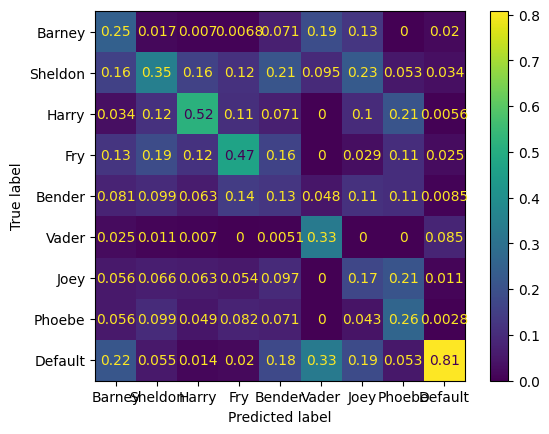

In [10]:
distilbert_model.train(
    characters_path = data_folder,
    model_path = embedder_path,
    train_embedder = True,
    verbose = True,
    patience = 5,
    test=True)

In [11]:
!zip -r /content/models.zip /content/models
from google.colab import files
files.download("/content/models.zip")

  adding: content/models/ (stored 0%)
  adding: content/models/distilbert_classifier/ (stored 0%)
  adding: content/models/distilbert_embedder/ (stored 0%)
  adding: content/models/distilbert_embedder/config.json (deflated 48%)
  adding: content/models/distilbert_embedder/tokenizer_config.json (deflated 45%)
  adding: content/models/distilbert_embedder/pytorch_model.bin (deflated 8%)
  adding: content/models/distilbert_embedder/special_tokens_map.json (deflated 42%)
  adding: content/models/distilbert_embedder/modules.json (deflated 67%)
  adding: content/models/distilbert_embedder/2_Normalize/ (stored 0%)
  adding: content/models/distilbert_embedder/tokenizer.json (deflated 71%)
  adding: content/models/distilbert_embedder/1_Pooling/ (stored 0%)
  adding: content/models/distilbert_embedder/1_Pooling/config.json (deflated 47%)
  adding: content/models/distilbert_embedder/config_sentence_transformers.json (deflated 27%)
  adding: content/models/distilbert_embedder/vocab.txt (deflated 53

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>